In [270]:
#データ入力
import pandas as pd
df = pd.read_csv("USD_JPY.csv")


In [271]:
#特徴量の作成
import talib as ta
import numpy as np

#全ての計算で終値を使う
close = np.array(df["終値"])

#特徴量を入れるための空のdataframeを作成
df_feature = pd.DataFrame(index=range(len(df)),columns=["SMA5/current", "SMA20/current","RSI","MACD","BBANDS+2σ","BBANDS-2σ"])

#以下、talibを用いてテクニカル指標（今回の学習で用いる特徴量）を算出しdf_feature入れる

#単純移動平均は、単純移動平均値とその日の終値の比を特徴量として用いる
df_feature["SMA5/current"]= ta.SMA(close, timeperiod=5) / close
df_feature["SMA20/current"]= ta.SMA(close, timeperiod=5) / close

#RSI
df_feature["RSI"] = ta.RSI(close, timeperiod=14)

#MACD
df_feature["MACD"], _ , _= ta.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)

#ボリンジャーバンド 
upper, middle, lower = ta.BBANDS(close, timeperiod=20, nbdevup=3, nbdevdn=3)
df_feature["BBANDS+2σ"] = upper / close
df_feature["BBANDS-2σ"] = lower / close


df["前日比_float"] = df["前日比%"].apply(lambda x: float(x.replace("%", "")))

#前日比%の分類の仕方。できるだけ各クラスのサンプルが等しいようにわける
def classify_1(x):
    if x <= -0.2:
        return 0
    elif -0.2 < x < 0.2:
        return 1
    elif 0.2 <= x:
        return 2
    
def classify_2(x):
    if x <= -0.40:
        return 1
    elif -0.4 < x <= -0.10:
        return 2
    elif -0.10 < x <= 0.10:
        return 3
    elif 0.10 < x <= 0.4:
        return 4
    elif 0.4 < x:
        return 5
def classify_3(x):
    if x <= 0:
        return 0
    else:
        return 1

df["前日比_classified"] = df["前日比_float"].apply(lambda x: classify_3(x))

df_y = df["前日比_classified"].shift()

df_xy = pd.concat([df_feature, df_y], axis=1)
df_xy = df_xy.dropna(how="any")

In [272]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import optuna

X_train, X_test, Y_train, Y_test = train_test_split(df_xy[["SMA5/current", "SMA20/current","RSI","MACD","BBANDS+2σ","BBANDS-2σ"]],df_xy["前日比_classified"], train_size=0.8)

def objective(trial):
    min_samples_split = trial.suggest_int("min_samples_split", 2,16)
    max_leaf_nodes = int(trial.suggest_discrete_uniform("max_leaf_nodes", 4,64,4))
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])
    n_estimators = int(trial.suggest_discrete_uniform("n_estimators", 50,500,50))
    max_depth = trial.suggest_int("max_depth", 3,10)
    clf = RandomForestClassifier(random_state=1, n_estimators = n_estimators, max_leaf_nodes = max_leaf_nodes, max_depth=max_depth, max_features=None,criterion=criterion,min_samples_split=min_samples_split)
    clf.fit(X_train, Y_train)
    return 1 - accuracy_score(Y_test, clf.predict(X_test))

study = optuna.create_study()
study.optimize(objective, n_trials=100)


[I 2020-07-29 23:57:10,661] Trial 0 finished with value: 0.23553299492385782 and parameters: {'min_samples_split': 5, 'max_leaf_nodes': 12.0, 'criterion': 'gini', 'n_estimators': 50.0, 'max_depth': 4}. Best is trial 0 with value: 0.23553299492385782.
[I 2020-07-29 23:57:14,052] Trial 1 finished with value: 0.23857868020304573 and parameters: {'min_samples_split': 8, 'max_leaf_nodes': 52.0, 'criterion': 'entropy', 'n_estimators': 200.0, 'max_depth': 7}. Best is trial 0 with value: 0.23553299492385782.
[I 2020-07-29 23:57:16,155] Trial 2 finished with value: 0.23147208121827412 and parameters: {'min_samples_split': 4, 'max_leaf_nodes': 32.0, 'criterion': 'gini', 'n_estimators': 200.0, 'max_depth': 7}. Best is trial 2 with value: 0.23147208121827412.
[I 2020-07-29 23:57:18,661] Trial 3 finished with value: 0.23654822335025383 and parameters: {'min_samples_split': 6, 'max_leaf_nodes': 44.0, 'criterion': 'entropy', 'n_estimators': 200.0, 'max_depth': 5}. Best is trial 2 with value: 0.231472

[I 2020-07-29 23:58:16,937] Trial 32 finished with value: 0.23147208121827412 and parameters: {'min_samples_split': 15, 'max_leaf_nodes': 60.0, 'criterion': 'gini', 'n_estimators': 100.0, 'max_depth': 7}. Best is trial 20 with value: 0.2253807106598985.
[I 2020-07-29 23:58:18,662] Trial 33 finished with value: 0.23147208121827412 and parameters: {'min_samples_split': 11, 'max_leaf_nodes': 52.0, 'criterion': 'gini', 'n_estimators': 150.0, 'max_depth': 8}. Best is trial 20 with value: 0.2253807106598985.
[I 2020-07-29 23:58:19,279] Trial 34 finished with value: 0.2263959390862944 and parameters: {'min_samples_split': 15, 'max_leaf_nodes': 60.0, 'criterion': 'gini', 'n_estimators': 50.0, 'max_depth': 8}. Best is trial 20 with value: 0.2253807106598985.
[I 2020-07-29 23:58:20,984] Trial 35 finished with value: 0.23147208121827412 and parameters: {'min_samples_split': 15, 'max_leaf_nodes': 60.0, 'criterion': 'entropy', 'n_estimators': 100.0, 'max_depth': 9}. Best is trial 20 with value: 0.2

[I 2020-07-29 23:59:03,334] Trial 64 finished with value: 0.2294416243654822 and parameters: {'min_samples_split': 14, 'max_leaf_nodes': 64.0, 'criterion': 'gini', 'n_estimators': 50.0, 'max_depth': 10}. Best is trial 20 with value: 0.2253807106598985.
[I 2020-07-29 23:59:03,879] Trial 65 finished with value: 0.2294416243654822 and parameters: {'min_samples_split': 13, 'max_leaf_nodes': 36.0, 'criterion': 'gini', 'n_estimators': 50.0, 'max_depth': 8}. Best is trial 20 with value: 0.2253807106598985.
[I 2020-07-29 23:59:05,041] Trial 66 finished with value: 0.2284263959390863 and parameters: {'min_samples_split': 15, 'max_leaf_nodes': 52.0, 'criterion': 'gini', 'n_estimators': 100.0, 'max_depth': 9}. Best is trial 20 with value: 0.2253807106598985.
[I 2020-07-29 23:59:05,639] Trial 67 finished with value: 0.2274111675126903 and parameters: {'min_samples_split': 12, 'max_leaf_nodes': 56.0, 'criterion': 'gini', 'n_estimators': 50.0, 'max_depth': 9}. Best is trial 20 with value: 0.22538071

[I 2020-07-29 23:59:35,982] Trial 96 finished with value: 0.23248730964467001 and parameters: {'min_samples_split': 13, 'max_leaf_nodes': 44.0, 'criterion': 'entropy', 'n_estimators': 50.0, 'max_depth': 8}. Best is trial 70 with value: 0.2233502538071066.
[I 2020-07-29 23:59:37,134] Trial 97 finished with value: 0.2294416243654822 and parameters: {'min_samples_split': 14, 'max_leaf_nodes': 48.0, 'criterion': 'gini', 'n_estimators': 100.0, 'max_depth': 9}. Best is trial 70 with value: 0.2233502538071066.
[I 2020-07-29 23:59:39,410] Trial 98 finished with value: 0.2284263959390863 and parameters: {'min_samples_split': 16, 'max_leaf_nodes': 52.0, 'criterion': 'gini', 'n_estimators': 200.0, 'max_depth': 7}. Best is trial 70 with value: 0.2233502538071066.
[I 2020-07-29 23:59:39,998] Trial 99 finished with value: 0.2253807106598985 and parameters: {'min_samples_split': 15, 'max_leaf_nodes': 44.0, 'criterion': 'gini', 'n_estimators': 50.0, 'max_depth': 8}. Best is trial 70 with value: 0.2233

In [273]:
print(1-study.best_value)
print(study.best_params)

0.7766497461928934
{'min_samples_split': 16, 'max_leaf_nodes': 52.0, 'criterion': 'gini', 'n_estimators': 50.0, 'max_depth': 8}


In [274]:
print(

0.2233502538071066

/Users/merry/.pyenv/versions/3.6.5/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/merry/.pyenv/versions/3.6.5/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1622.,    0.,    0.,    0.,    0., 1654.,    0.,    0.,    0.,
        1680.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

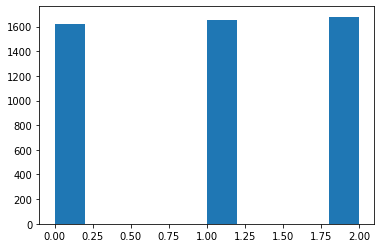

In [251]:
import matplotlib.pyplot as plt
plt.hist(df_y)